In [1]:
%load_ext autoreload
%autoreload 2
import torch
import cv2
import numpy as np
from kornia.geometry import denormalize_pixel_coordinates
from torch.testing import assert_close
from courtvision.trackers import Tracker, StateIdx
import rerun as rr
from courtvision.geometry import solve_for_camera_matrix, solve_for_projection_matrix

In [2]:
from courtvision.geometry import corners_world_3d, convert_corners_to_coords

print(corners_world_3d.keys())
convert_corners_to_coords(corners_world_3d)
from courtvision.geometry import get_corners_image, get_corners_verital_plane_on_image

corners_image = get_corners_image("curated_001/curated_001_frame_0001")
corners_image_other = get_corners_verital_plane_on_image(
    "curated_001/curated_001_frame_0001", plane="both"
)
corners_image.update(corners_image_other)

for k in list(corners_world_3d.keys()):
    if k not in corners_image:
        print(f"removing {k}")
        corners_world_3d.pop(k)


corners_image.keys()
corners_world_3d.keys()

dict_keys(['a_front_left', 'b_front_right', 'c_back_left', 'd_back_right', 'e_left_near_serve_line', 'f_right_near_serve_line', 'g_left_far_serve_line', 'h_right_far_serve_line', 'i_center_line_far', 'j_net_line_left', 'k_center_line_near', 'l_net_line_right', 'm_top_front_left', 'n_top_front_right', 'o_top_back_left', 'p_top_back_right'])
removing i_center_line_far
removing j_net_line_left
removing k_center_line_near
removing l_net_line_right


dict_keys(['a_front_left', 'b_front_right', 'c_back_left', 'd_back_right', 'e_left_near_serve_line', 'f_right_near_serve_line', 'g_left_far_serve_line', 'h_right_far_serve_line', 'm_top_front_left', 'n_top_front_right', 'o_top_back_left', 'p_top_back_right'])

In [3]:
image_size = (1280, 720)
world_points = torch.tensor(
    convert_corners_to_coords(corners_world_3d), dtype=torch.float64
)

image_points = torch.tensor(
    convert_corners_to_coords(corners_image), dtype=torch.float64
)

camera_matrix, dist_coeffs, reproj_error = solve_for_camera_matrix(
    world_points=world_points[:8],
    image_points=image_points[:8],
    image_size=image_size,
)


projection_matrix, tvec = solve_for_projection_matrix(
    world_points=world_points.numpy(),
    image_points=image_points.numpy(),
    camera_matrix=camera_matrix,
    dist_coeffs=dist_coeffs,
    in_object_coordinate_frame=True,
)

In [8]:
np.sqrt(tvec[0] ** 2 + tvec[1] ** 2 + tvec[2] ** 2), tvec

(array([1618.39871437]),
 array([[  123.40760714],
        [ -449.13034974],
        [-1549.92480144]]))

In [5]:
from courtvision.geometry import transfrom_points, convert_points_to_homogeneous

# Transform object points to camera frame
objectPoints_camera = transfrom_points(
    points=world_points.numpy(), transformation_matrix=projection_matrix, tvec=tvec
)
print(objectPoints_camera.shape)
# objectPoints_camera = np.array([objectPoints_camera[:,1],objectPoints_camera[:,0],objectPoints_camera[:,2]]).T
# permuted_arr = np.array([arr[2], arr[1], arr[0]])
objectPoints_camera.shape, world_points.numpy().shape

(12, 3)


((12, 3), (12, 3))

In [6]:
import rerun as rr

if False:
    rr.init("Blueprint demo")
    rr.start_web_viewer_server()
    rec = rr.memory_recording()
else:
    from random import randint
    import string

    dd = "".join(
        [
            string.ascii_letters[randint(0, len(string.ascii_letters) - 1)]
            for i in range(10)
        ]
    )
    rr.init(dd, spawn=True)
rr.set_time_sequence("frame_nr", 0)
i = 0

[2023-05-29T20:00:25Z WARN  re_sdk::global] There is no currently active Blueprint recording available for the current thread (ThreadId(1)): have you called `set_global()` and/or `set_thread_local()` first?


In [7]:
i = i + 1
print(i)
rr.set_time_sequence("frame_nr", i)
rr.log_view_coordinates("camera", up="+Z", right_handed=True, timeless=False)
# rr.log_view_coordinates("world",xyz="RFU", timeless=True)

# rr.log_rigid3(
#             "world/camera",
#             child_from_parent=(translation_xyz,quat_xyzw),

#             # xyz="RFD",  # X=Right, Y=Down, Z=Forward
#         )
# rr.log_transform3d("camera",
#                    transform=from_camera_to_world,
#                    from_parent=False,
#                    )

rr.log_pinhole(
    "camera/image",
    child_from_parent=camera_matrix,
    width=image_size[0],
    height=image_size[1],
    #   timeless=True,
)
img = cv2.imread(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0001.png"
)
print(img.shape)
img = cv2.resize(img, (1280, 720))
print(img.shape)
rr.log_image("camera/image", img)
# rr.log_points("world/camera/imgae",
#               positions=denormalize_pixel_coordinates(image_points,height=image_size[1],width=image_size[0]),
#               )
rr.log_point(
    "camera/origin",
    position=torch.tensor([0.0, 0.0, 0.0]),
    color=(1.0, 0.0, 0.0),
    radius=10.0,
)

rr.log_point(
    "camera/x",
    position=torch.tensor([20.0, 0.0, 0.0]),
    color=(1.0, 1.0, 0.0),
    radius=10.0,
)
rr.log_point(
    "camera/y",
    position=torch.tensor([0.0, 20.0, 0.0]),
    color=(1.0, 1.0, 0.0),
    radius=10.0,
)
rr.log_point(
    "camera/z",
    position=torch.tensor([0.0, 0.0, 20.0]),
    color=(1.0, 1.0, 0.0),
    radius=10.0,
)
rr.log_arrow(
    "camera/front_left_to_back_left",
    origin=objectPoints_camera[0],
    vector=objectPoints_camera[2] - objectPoints_camera[0],
    color=(0.0, 0.0, 1.0),
)
rr.log_arrow(
    "camera/front_right_to_back_right",
    origin=objectPoints_camera[1],
    vector=objectPoints_camera[3] - objectPoints_camera[1],
    color=(0.0, 0.0, 1.0),
)
rr.log_points(
    "camera/court_points",
    positions=objectPoints_camera[2:],
    colors=torch.tensor([1.0, 0.0, 0.0]),
    radii=100.0,
)
rr.log_points(
    "camera/court_points_front",
    positions=objectPoints_camera[:2],
    colors=torch.tensor([1.0, 1.0, 0.0]),
    radii=100.0,
)
rr.log_obb(
    "camera/court",
    half_size=(300.0, 1000.0, 500.0),
    position=(300.0, 1000.0, 500.0),
    stroke_width=3.0,
)


# rr.log_obb("world/court2",
#            half_size=(5000.0/2, 20000.0/2, 3000.0/2),
#            position=(2500.0, 1000.0, 1500.0),
# )
# rr.log_point("world/points_ball", position=torch.tensor([0.0, 0.0, 0.0]),color=(0.0, 0.0, 1.0), radius=10.0)
# # rr.log_points("world/court_points", positions=world_points, colors=torch.tensor([1.0, 0.0, 0.0]),radii=1000.0)
# rr.log_point("world/points_ball", position=torch.tensor([500.0, 1000.0, 300.0]),color=(0.0, 0.0, 1.0), radius=10.0)

1
(720, 1280, 3)
(720, 1280, 3)


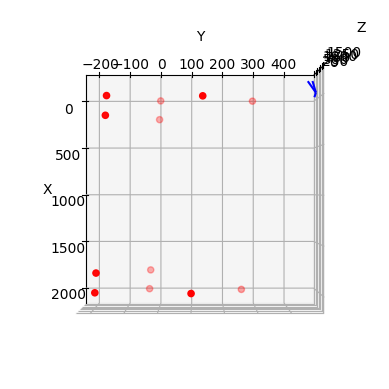

In [14]:
# %matplotlib notebook

import matplotlib.pyplot as plt

camera_points = objectPoints_camera
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot world points in green
# ax.scatter(world_points[:, 0], world_points[:, 1], world_points[:, 2], c='green')

# Plot camera points in red
ax.scatter(camera_points[:, 0], camera_points[:, 1], camera_points[:, 2], c="red")


camera_position = -tvec
# The camera orientation is the third column of the rotation matrix (or the third row, depending on the convention used).
camera_orientation = (
    projection_matrix[:, 2]
    if projection_matrix.shape[0] == 3
    else projection_matrix[2, :]
)

# Plot camera as an arrow
ax.quiver(
    camera_position[0],
    camera_position[1],
    camera_position[2],
    camera_orientation[2],
    camera_orientation[1],
    camera_orientation[0],
    length=1000.0,
    color="blue",
)

# Adding labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=90, azim=0)
# Show the plot
plt.show()

In [27]:
tvec

array([[-2093.20904117],
       [ -644.60521486],
       [  650.60182588]])

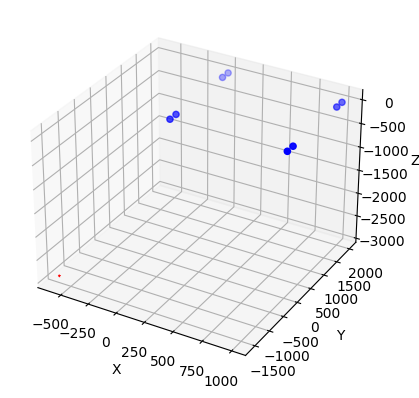

In [172]:
import matplotlib.pyplot as plt

# Transform object points
objectPoints = world_points.numpy()
objectPoints_transformed = objectPoints  # np.dot(projection_matrix[:3,:3], objectPoints.T).T + projection_matrix[:3,3]

# Get camera direction from rotation matrix
camera_direction = -projection_matrix[
    :, 2
]  # In OpenGL convention, camera is looking down the negative z-axis

# Create a new figure and add a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the transformed object points
ax.scatter(
    objectPoints_transformed[:, 0],
    objectPoints_transformed[:, 1],
    objectPoints_transformed[:, 2],
    c="b",
    marker="o",
)

# Plot the camera location as a red arrow
ax.quiver(
    translation_xyz[0],
    translation_xyz[1],
    translation_xyz[2],
    camera_direction[0],
    camera_direction[1],
    camera_direction[2],
    color="r",
    length=100.5,
)

# Add labels to the axes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [49]:
translation_xyz

array([ 5.02635904e+02, -2.13946340e+03,  1.71047864e+00])

In [29]:
# Define the 3D point in homogeneous coordinates
# P_hom = np.array([[X], [Y], [Z], [1]], dtype=np.float32)

# # Project the 3D point to the image plane using the projection matrix
# P_proj_hom = np.dot(P, P_hom)

# # Normalize the image coordinates
# P_proj = P_proj_hom[:2] / P_proj_hom[2]

# # Print the projected point on the image plane
# print("Projected point:", P_proj)

In [ ]:
rr.log_extension_components

In [37]:
import torch
import kornia
from courtvision.geometry import corners_world_3d

#  REF https://ksimek.github.io/2013/08/13/intrinsic/
world_points = torch.tensor(
    convert_corners_to_coords(corners_world_3d), dtype=torch.float64
).unsqueeze(0)

img_points = torch.tensor(
    convert_corners_to_coords(corners_image), dtype=torch.float64
).unsqueeze(0)
# print(f"{img_points=}")
from kornia.geometry.conversions import (
    normalize_pixel_coordinates,
    denormalize_pixel_coordinates,
    normalize_pixel_coordinates3d,
)

img_points_N = normalize_pixel_coordinates(img_points, width=1280, height=720)
img_points_d = denormalize_pixel_coordinates(img_points_N, width=1280, height=720)
# print(f"{img_points_d=}")
fx = 1000
fy = 1000
cy = 720 / 2

cx = 1280 / 2


intrinsics = torch.tensor(
    [
        [
            [fx, 0.0, cx],
            [0.0, fy, cy],
            [0.0, 0.0, 1.0],
        ]
    ],
    dtype=torch.float64,
)

print(world_points.shape, img_points.shape, intrinsics.shape)
# torch.Size([1, 6, 3]) torch.Size([1, 6, 2]) torch.Size([1, 3, 3])
world_points_N = normalize_pixel_coordinates3d(
    world_points, depth=2000.0, height=300.0, width=1000.0
)
# Solve PnP
import cv2
import numpy as np

dist_coeffs = np.array([0, 0, 0, 0, 0], dtype=np.float32)

success, rvec, tvec = cv2.solvePnP(
    world_points.numpy(),
    img_points_N.numpy(),
    intrinsics.squeeze(0).numpy(),
    dist_coeffs,
    flags=cv2.SOLVEPNP_ITERATIVE,
    useExtrinsicGuess=False,
)
print(f"{success=}")
# Convert rotation vector to rotation matrix
rmat, _ = cv2.Rodrigues(rvec)

# Concatenate rotation matrix and translation vector to create a 3x4 transformation matrix
transformation_matrix = np.hstack((rmat, tvec))
print(f"{transformation_matrix=}")
#    {rvec=} {tvec=}")
pred_world_to_cam = kornia.geometry.solve_pnp_dlt(
    world_points_N, img_points_N, intrinsics, svd_eps=0.0000000001
)

# print(pred_world_to_cam.shape)
print(f"{pred_world_to_cam=}")
# torch.Size([1, 3, 4])

# pred_world_to_cam
# world_points_N

torch.Size([1, 16, 3]) torch.Size([1, 12, 2]) torch.Size([1, 3, 3])


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/solvepnp.cpp:833: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'


In [33]:
import numpy as np


def calculate_reprojection_error_using_projection_matrix(
    objpoints, imgpoints, projection_matrix
):
    mean_error = 0
    for i in range(len(objpoints)):
        # convert the object point to homogeneous coordinates
        objpoint_homogeneous = np.hstack((objpoints[i], 1))
        # project the object point
        imgpoint_projected_homogeneous = np.dot(projection_matrix, objpoint_homogeneous)
        # convert the projected point from homogeneous to cartesian coordinates
        imgpoint_projected = (
            imgpoint_projected_homogeneous[:2] / imgpoint_projected_homogeneous[2]
        )
        # calculate the error
        error = np.linalg.norm(imgpoints[i] - imgpoint_projected)
        mean_error += error
    return mean_error / len(objpoints)


print(
    calculate_reprojection_error_using_projection_matrix(
        world_points_N.squeeze(0).numpy(),
        img_points_N.squeeze(0).numpy(),
        pred_world_to_cam.squeeze(0).numpy(),
    )
)
calculate_reprojection_error_using_projection_matrix(
    world_points_N.squeeze(0).numpy(),
    img_points_N.squeeze(0).numpy(),
    transformation_matrix,
)

1.0996793425628677


0.7312957762435465

In [155]:
import numpy as np
import cv2

# Assume you have the following required variables
# mtx: Camera matrix
# dist: Distortion coefficients
# rvecs: Rotation vectors
# tvecs: Translation vectors
# objpoints: 3d point in real world space
# imgpoints: 2d points in image plane


def calculate_reprojection_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        mean_error += error
    return mean_error / len(objpoints)


reprojection_error = calculate_reprojection_error(
    world_points_N.numpy(), img_points_N.numpy(), rvecs, tvecs, mtx, dist
)

print("reprojection error: ", reprojection_error)

torch.Size([1, 1, 3, 3])

In [160]:
tvec, rvec

(array([[-1939726.92634732],
        [-1090176.10143233],
        [ 2426190.30146557]]),
 array([[ 1.73129197],
        [-0.4755916 ],
        [ 1.13913989]]))

In [143]:
pred_world_to_cam.shape

torch.Size([1, 3, 4])

In [136]:
tracker = Tracker(num_particles=1000, world_to_cam=pred_world_to_cam)

In [137]:
tracker.H.to(dtype=torch.float32)

tensor([[[-5.8979e-01,  7.1178e-01, -3.8146e-01,  9.6423e+02],
         [-3.3216e-01,  2.1675e-01,  9.1798e-01,  5.4303e+02],
         [ 7.3609e-01,  6.6812e-01,  1.0859e-01, -1.2034e+03]]])

In [148]:
obs_in_image = torch.tensor([[1.0, 1.0]]).repeat(1000, 1)
[0.8944, 0.8864],
from kornia.geometry.conversions import normalize_homography3d

tracker.set_states_to(torch.tensor([-1.0, -1.0, -1.0]))
dd = Tracker.state_to_observation(
    tracker.states, tracker.H.to(dtype=torch.float32).squeeze(0)
)
dd, img_points_N

(tensor([[-0.8005, -0.4500],
         [-0.8005, -0.4500],
         [-0.8005, -0.4500],
         ...,
         [-0.8005, -0.4500],
         [-0.8005, -0.4500],
         [-0.8005, -0.4500]]),
 tensor([[[-0.9998, -0.9976],
          [-0.9986, -0.9975],
          [-0.9995, -0.9992],
          [-0.9989, -0.9992],
          [-0.9997, -0.9980],
          [-0.9987, -0.9980],
          [-0.9995, -0.9990],
          [-0.9989, -0.9990],
          [-0.9999, -0.9986],
          [-0.9986, -0.9986],
          [-0.9995, -0.9998],
          [-0.9989, -0.9981]]], dtype=torch.float64))

In [145]:
dd

tensor([[-0.8012, -0.4512],
        [-0.8012, -0.4512],
        [-0.8012, -0.4512],
        ...,
        [-0.8012, -0.4512],
        [-0.8012, -0.4512],
        [-0.8012, -0.4512]])

In [109]:
img_points.min()

tensor(0.0870, dtype=torch.float64)

In [150]:
import cv2
import numpy as np

# 3D object points in world coordinates
object_points = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]], dtype=np.float32)

# 2D image points in image coordinates
image_points = np.array([[10, 10], [20, 10], [10, 20], [20, 20]], dtype=np.float32)

# Camera intrinsic matrix (fx, fy, cx, cy)
camera_matrix = np.array([[500, 0, 320], [0, 500, 240], [0, 0, 1]], dtype=np.float32)

# Distortion coefficients (k1, k2, p1, p2, k3)
dist_coeffs = np.array([0, 0, 0, 0, 0], dtype=np.float32)

# Solve PnP
success, rvec, tvec = cv2.solvePnP(
    object_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_UPNP
)
print(f"{success=} {rvec=} {tvec=}")

success=True rvec=array([[0.],
       [0.],
       [0.]]) tvec=array([[-31.75634152],
       [-23.55795647],
       [ 51.23990293]])


In [77]:
repo_erro, camera_matrix, dist_coeffs, *_ = cv2.calibrateCamera(
    objectPoints=[world_points.squeeze(0).numpy().astype(np.float32)[:-4]],
    imagePoints=[img_points.squeeze(0).numpy().astype(np.float32)[:-4]],
    imageSize=(1280, 720),
    cameraMatrix=None,
    distCoeffs=None,
)
dist_coeffs
repo_erro > 1e-2

True

In [70]:
world_points.numpy().shape

(1, 12, 3)

In [66]:
[world_points.squeeze(0).numpy().astype(np.float32)[:-4]]

[array([[   0.,    0.,    0.],
        [1000.,    0.,    0.],
        [   0., 2000.,    0.],
        [1000., 2000.,    0.],
        [   0.,  200.,    0.],
        [1000.,  200.,    0.],
        [   0., 1800.,    0.],
        [1000., 1800.,    0.]], dtype=float32)]

TypeError: 'str' object cannot be interpreted as an integer

else
finally
